# Day 2: Automatic differentiation, and introduction to CUDA

## Automatic differentiation

Having knowledge of the gradients of a multivariable function with respect to its arguments is a powerful tool in mathematical computations, e.g., in
- computing Hessians for optimization problems or extracting uncertainties in a likelihood:
$$\begin{bmatrix} \frac{\delta^2 f}{\delta x_1^2} & \frac{\delta^2 f}{\delta x_1 \delta x_2} \\ \frac{\delta^2 f}{\delta x_1 \delta x_2} & \frac{\delta^2 f}{\delta x_2^2} \end{bmatrix}$$
- computing gradients to find descent to minimum loss in machine learning:
$$\vec{x}_{n+1} = \vec{x}_n - \gamma \nabla L(\vec{x})|_{\vec{x}=\vec{x}_n}$$


There are several ways to compute gradients:
- Use symbolic language that maps function names to their definitions and other functions for derivatives. Here is an example using Mathematica:

![Derivatives in Mathematica](mathematica_screnshot_diff.png)

- Use numerical differentiation with small step sizes.
- Embed differentials into variable definitions in programming (**automatic differentiation** - topic of today!).

Suppose we have a function $f(g(h(x)))$. The chain rule gives us
$$v=h(x)$$
$$u=g(v)$$
$$y=f(u)$$
$$\frac{\delta f}{\delta x} = \frac{\delta y}{\delta u} \frac{\delta u}{\delta v} \frac{\delta v}{\delta x}$$

This gives us two directions from which we can start differentiation:
- Forward: $\frac{\delta y}{\delta u} \frac{\delta u}{\delta v} \frac{\delta v}{\delta x} \leftarrow$ start computing derivatives in this direction.
- Reverse: start computing derivatives in this direction $\rightarrow \frac{\delta y}{\delta u} \frac{\delta u}{\delta v} \frac{\delta v}{\delta x}$.

Why does it matter? Don't we have the same number of derivatives?

$\rightarrow$ That is correct, but for a function $f: U^n \to V^m$, we would have a different number of matrix multiplication steps (derivatives $\equiv$ Jacobian matrices). For the sake of example, assume the dimensionality $k$ for both $g$ and $h$. Then,
- forward differentiation involves $(n \times k^2) + (n \times k \times m)$ multiplications, whereas
- reverse differentiation would need $(m \times k^2) + (n \times k \times m)$ multiplications.

If $n \cong m$, or $k$ is not large compared to $n$ or $m$, the direction does not matter much. On the other hand, if $k$ is large, it is better to use forward differentiation for $n \ll m$, and reverse differentiation otherwise.

In a typical neural network, gradient descent uses *forward propagation* to calculate the cost for a given loss function , and *backpropagation* (through reverse autodifferentiation - **why?**) to calculate gradients of the cost with respect to the weights at each layer.

### Exercise: Dual numbers
Consider an extension of a real variable $r \to (r, \delta r)$. Denoting $u = (x, \delta x)$ and $v = (y, \delta y)$, define the minimal set of algebraic properties as follows:
- $-u = (-x, -\delta x)$
- $u^{-1} = (1/x, -\delta x/x^2)$
- $u+v = (x+y, \delta x + \delta y)$
- $u \times v = (x \times y, y \times \delta x + x \times \delta y)$

For $f(x, y) = x^{2 y^3}$, write a simple Python script to compute $f(2,3)$ and $\frac{\delta f}{\delta y} |_{(x,y)=(2,3)}$.

#### Solution:

In [1]:
import numpy as np

class DualValue:
  def __init__(self, value, differential):
    self.value = value
    self.differential = differential
  def __add__(self, other):
    return DualValue(self.value + other.value, self.differential + other.differential)
  def __radd__(self, other):
    return DualValue(self.value + other, self.differential)
  def __sub__(self, other):
    return DualValue(self.value - other.value, self.differential - other.differential)
  def __rsub__(self, other):
    return DualValue(other - self.value, -self.differential)
  def __mul__(self, other):
    return DualValue(self.value * other.value, self.differential * other.value + self.value * other.differential)
  def __rmul__(self, other):
    return DualValue(self.value * other, self.differential * other)
  def __truediv__(self, other):
    return DualValue(self.value / other.value, (self.differential * other.value - self.value * other.differential) / (other.value * other.value))
  def __rtruediv__(self, other):
    return DualValue(other / self.value, -self.differential * other / (self.value * self.value))
  def __neg__(self):
    return DualValue(-self.value, -self.differential)
  def __lt__(self, other):
    return self.value < other.value
  def __le__(self, other):
    return self.value <= other.value
  def __eq__(self, other):
    return self.value == other.value
  def __ne__(self, other):
    return self.value != other.value
  def __gt__(self, other):
    return self.value > other.value
  def __ge__(self, other):
    return self.value >= other.value
  def __abs__(self):
    return DualValue(abs(self.value), self.differential * np.sign(self.value))
  def __str__(self):
    return str(self.value)
  def __pow__(self, other):
    if isinstance(other, DualValue):
      return DualValue(self.value**other.value, self.value**other.value * other.differential * np.log(self.value) + self.differential * other.value * self.value**(other.value - 1))
    else:
      return DualValue(self.value**other, other * self.value**(other - 1) * self.differential)
  def __rpow__(self, other):
    return DualValue(other**self.value, other**self.value * self.differential * np.log(other))
  
x = DualValue(2, 0)
y = DualValue(3, 1)

f = x**(2*y**3)
print(f.value, f.differential)

18014398509481984 6.742779949618588e+17


## Using Tensorflow for automatic differentiation

The main TensorFlow object that allows tracking gradients with respect to some input operations is `GradientTape`. Here is an example way to use it:

In [6]:
import tensorflow as tf

# Could have also written
# x = tf.Variable(2.)
# but not
# x = tf.Variable(2)
# Integer types are not considered differentiable by default.
x = tf.Variable(2, dtype=tf.float64)
y = tf.Variable(3, dtype=tf.float64)
with tf.GradientTape() as tape:
  f = x**(2*y**3)

df = tape.gradient(f, [x, y])

print(f"F(2,3) = {f.numpy()}")
print(f"df/dx | (x,y)=(2,3) = {df[0].numpy()}")
print(f"df/dy | (x,y)=(2,3) = {df[1].numpy()}")

F(2,3) = 1.8014398509481984e+16
df/dx | (x,y)=(2,3) = 4.863887597560136e+17
df/dy | (x,y)=(2,3) = 6.742779949618587e+17


You can also take second-order derivatives. Note that a GradientTape is released as soon as you call the function `gradient`, unless you make it a persistent object.

In [3]:
x = tf.Variable(2, dtype=tf.float64)
y = tf.Variable(3, dtype=tf.float64)

with tf.GradientTape(persistent=True) as t2:
  with tf.GradientTape() as t1:
    f = x**(2*y**3)
  df = t1.gradient(f, [x, y])
d_df_dx = t2.gradient(df[0], [x, y])
d_df_dy = t2.gradient(df[1], [x, y])

print("d2 f / dx2 = ", d_df_dx[0].numpy())
print("d2 f / dxdy = ", d_df_dx[1].numpy())
print("d2 f / dydx = ", d_df_dy[0].numpy()) # Should be the same as d2 f / dxdy
print("d2 f / dy2 = ", d_df_dy[1].numpy())
del(t2)

d2 f / dx2 =  1.288930213353436e+19
d2 f / dxdy =  1.8691894623726203e+19
d2 f / dydx =  1.86918946237262e+19
d2 f / dy2 =  2.5687708783864877e+19


By default, constants and tensors are not watched. You can instruct the `GradientTape` to watch them.

In [4]:
w = tf.constant(np.array([0, 2, 0, 0,  -0.5, 0, 0, 0,  0, 0, 0, -1,  0, 0, 1, 0]).reshape(4, 4), dtype=tf.float64)
x = tf.Variable(np.array([1, 2, 3, 4]).reshape(4,1), dtype=tf.float64)
b = tf.constant(np.array([0, 0, 0, 0]).reshape(4, 1), dtype=tf.float64)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(w)
  tape.watch(b)
  y = w @ x + b
  z = tf.reduce_sum(y**2)

dz_dw = tape.jacobian(z, w)
dz_dx = tape.jacobian(z, x)
dz_db = tape.jacobian(z, b)
print(f"dz/dw = {dz_dw.numpy()}")
print(f"dz/dx = {dz_dx.numpy()}")
print(f"dz/db = {dz_db.numpy()}")
del(tape)

dz/dw = [[  8.  16.  24.  32.]
 [ -1.  -2.  -3.  -4.]
 [ -8. -16. -24. -32.]
 [  6.  12.  18.  24.]]
dz/dx = [[ 0.5]
 [16. ]
 [ 6. ]
 [ 8. ]]
dz/db = [[ 8.]
 [-1.]
 [-8.]
 [ 6.]]


### Exercise: Mean squared error (MSE) function for a linear data with uncertainties

Collect 100 random data points between $0 \le x \le 1$ that could fit $y=3x+2$, with $\sigma_y=0.1$.

Write an MSE to describe the data and fit it using TensorFlow.

#### Solution:

Fitted a = 3.026333497308643, b = 1.989252300471401


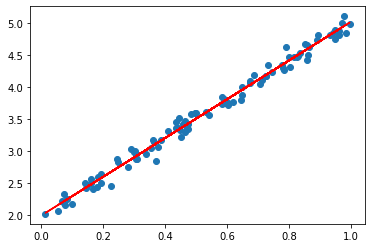

In [5]:
import matplotlib.pyplot as plt

xdata = np.random.rand(100, 1)
ydata = 3*xdata + 2 + np.random.randn(100, 1)/10

a = tf.Variable(0, dtype=tf.float64)
b = tf.Variable(0, dtype=tf.float64)
x = tf.constant(xdata, dtype=tf.float64)
yobs = tf.constant(ydata, dtype=tf.float64)

learning_rate = 0.05
for i in range(2000):
  with tf.GradientTape() as tape:
    y = a*x+b
    mse = tf.reduce_sum((y - yobs)**2/xdata.shape[0])
  da, db = tape.gradient(mse, [a, b])
  a.assign_sub(learning_rate*da)
  b.assign_sub(learning_rate*db)

del(tape)

plt.scatter(xdata, ydata)
plt.plot(xdata, a*xdata+b, 'r')

print(f"Fitted a = {a.numpy()}, b = {b.numpy()}")

## Introduction to CUDA

(For this part of the tutorial, it is best if you connect to `lxplus-gpu.cern.ch`. Refer to the 'GPU' folder in the main directory for a good makefile and other coding material.)

CUDA provides a heterogeneous computing model you can use to utilize GPUs in your calculations. The concepts discussed here are more or less transferable to other frameworks (oneAPI, Alpaka etc.), so learning CUDA is a good introduction to using any of the other GPU computing models.

In CUDA, the keyword `__device__` (two underscores on each side) refers to the GPU and its memory, and the keyword `__host__` refers to the CPU and the memory associated with it. The distinction goes a bit beyond a regular marker for execution preference: The code itself can be different for the `__host__` and `__device__`. Functions that execute in each of these contexts need to be receive these decorators upfront. If no decorators are specified for a function, `__host__` will be assumed. If you declare a function at one place in the code and define it somewhere else, you need to use the keywords consistently in both places.

```
void print(int); // __host__ is assumed
//__host__ void print(int); // Error: Function signature already defined!
__host__ void print(double); // Ok. Different function signature, running on the CPU.
__device__ void print_device(int); // Running on GPU.
__host__ __device__ void print_any(int); // Can run on both CPU and GPU. Declaration.

__host__ __device__ void print_any(int){ // Definition.
  printf("print_any: %d\n"); // We will come back to why printf is used here instead of std::cout (any thoughts?).
}

```

The keywords are also applicable in classes, so when you define your classes, make sure you use these decorators in member functions (not for data members).

```
template<typename T> struct TestClass{ // Oh no, not this template class again! :)
  T x;

  __host__ __device__ TestClass(T const& x) : x(x){}
  __host__ __device__ operator T() const{ return x; }
}
```

The way to run *anything* (with appropriate decorators and proper memory access) on a GPU is to run **kernel** functions. These functions are identified with the special decorator `__global__`. The difference between a kernel and device function is that the kernel function is your entry point, whereas a device function is a function you can call after you enter the kernel. Here is a simple call chain:
```
__device__ void print_data(data_t const& d_el){
  // Implementation goes here.
}

// data: A pointer to some generic data array - make sure it is accessible to the GPU!
// n: Total number of data elements
__global__ void print_kernel(unsigned int n, data_t* data){
  // We need to know which thread we are running.
  // Map block and thread indices to a data element index.
  unsigned int i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i<n) print_data(data[i]); // We could specify as many threads we would like, even more than the size of data.
}
```

Notice in this example that we used special variables `blockIdx` and `threadIdx`. These variables are visible in all kernel and device functions, and they have `x`, `y`, and `z` coordinates, with `y` and `z` trivially defaulted their dimensionality is not explicitly specified in the call of the kernel in the CPU execution context.

Here is a main function that could call this kernel:

```
#include "cuda_runtime.h" // Main header file to get defined variables, CUDA functions etc.
#include <cstdio> // Functions (such as printf) in cstdio are supported by CUDA to run on both host and device.
#include <cuda/std/cassert> // CUDA has its own implementation of assert.


// Fancy way to check an error in a CUDA function call
#define __CUDA_CHECK_OR_EXIT_WITH_ERROR__(CALL) \
{ \
  auto __cuda_error_code__ = CALL; \
  if (__cuda_error_code__ != cudaSuccess){ \
    printf("*** CUDA call ***\n*** '%s' ***\n*** at ***\n*** %s::%d ***\n*** failed with error '%s'. ***\n", #CALL, __FILE__, __LINE__, cudaGetErrorString(__cuda_error_code__)); \
    assert(false); \
  } \
}

using data_t = int; // Let's keep it simple for the sake of this example...

// ... print_data, print_kernel ...

int main(){
  constexpr unsigned int n = 5;
  data_t h_data[n]={1, 2, 3, 4, 5};

  // Need to make the data visible to the GPU first,
  // so you need to allocate memory on the GPU...
  data_t* d_data = nullptr;
  __CUDA_CHECK_OR_EXIT_WITH_ERROR__(cudaMalloc((void**) &d_data, n*sizeof(data_t)))

  // ...and copy the data from the host.
  __CUDA_CHECK_OR_EXIT_WITH_ERROR__(cudaMemcpy(d_data, h_data, n*sizeof(data_t), cudaMemcpyHostToDevice))

  // Execute the kernel for 1 thread block with 5 threads per block.
  print_kernel<<<1, n>>>(n, d_data);

  // Not needed in this example, but we could use cudaMemcpy with cudaMemcpyDeviceToHost to copy data back to host.

  // Free the memory on device
  __CUDA_CHECK_OR_EXIT_WITH_ERROR__(cudaFree(d_data))
}
```

### Different memory types

CUDA supports different ways to access memory, particularly in newer NVIDIA GPUs:
- Host memory: This is just the regular memory space of the CPU.
- Device memory: This would be memory allocated on the GPU via `cudaMalloc` (or N-D variants). Note that implicit in this call is the choice of the GPU device, which you can change via `cudaSetDevice(idx_device)` (see [CUDA device management API](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__DEVICE.html) for details).
- Unified memory: When memory is allocated as unified, it will be accessible to both the CPU and the GPU. This is useful especially when you have multiple GPUs in the system, accessing the same memory space. You can allocate this type of memory using `cudaMallocManaged` (see the [Memory Management](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__MEMORY.html) section of the CUDA Runtime API).
- Page-locked memory: When you normally allocate memory on the host, it is *pageable*, but is not directly accessible to the GPU yet. When you execute a `cudaMemcpy`, this pageable memory is copied to a pinned (page-locked) location from which the GPU can then communicate. Allocating page-locked memory, via `cudaMallocHost`, avoids this extra step by performing pinned memory allocation. This is advised to be a scarce resource, so use it judiciously.

Each of these memory allocation calls come with their own versions to free the memory:
- Host memory: Use regular calls to `free`.
- Device memory: `cudaFree` (can be asynchronous, see material in the next part for the latter).
- Unified memory: `cudaFree`.
- Page-locked memory: `cudaFreeHost`.

#### `__shared__` memory
This is a type of memory that is shared within each block. You can request this memory in two ways:
- By statically allocating within the kernel
```
__global__ void kernel(...){
  __shared__ int s[64]; // Allocate a shared memory block of 64*sizeof(int)
  // ...
}
```
- by dynamically allocating at the time of the kernel call:
```
__global__ void kernel(...){
  extern __shared__ int s[];
  // ...
}
//...
kernel<<<nblocks, nthreads_per_block, n*sizeof(int)>>>(...);
```
In both cases, you can only allocate the shared memory once. You can allocate a bigger block and split it using type recasts if you need multiple shared objects.

Using shared memory allows you to share information across threads. However, you need to note that not all threads start at the same time. For that reason, any assignment to the shared objects that will be used in another thread will need to synchronize the threads first:
```
__global__ void kernel(...){
  // Stuff before does not access shared memory
  __syncthreads(); // Call this before accessing shared objects that would have been assigned in another thread.
  // Can use shared value from another thread now
}
```

### Exercise: Rewrite exercise_templates.cc with CUDA

We already covered how `TestClass` would look like. Let's rewrite the entire file and print the statements using GPUs. Add a GPU printout of 1000 `TestClass<TestClass<double>>` objects.

#### Solution:

Check the file exercise_templates_CUDA.cc for an example way.

Notice in the file the call to `cudaDeviceSynchronize`. Calls to GPU and CPU are executed in the order they are issued, but once you make a series of calls to the GPU, they execute concurrently with the rest of the CPU calls. For that reason, before you destruct/deallocate any object that might still be in use by the GPU, you need to make sure that the work of the GPU with that object is complete.

Following the example, the call `free(h_ccx)` could start as soon as the kernel call is issued, right after the `cudaMemcpy` request that also involves `h_cxx` as well. For a large enough `h_cxx` array size, the CPU free operation could start before the CUDA memory copy is complete, unless you ensure the device synchronizes first.

### A note on virtual inheritance

CUDA device code does not support runtime type information (RTTI).

CUDA device code does not support runtime type information (RTTI).

This is not a typo. CUDA device code does not support RTTI!

This means, in device code,
- `dynamic_cast` is disallowed.
- `typeid` is disallowed.
- you may not call any of the virtual functions (including anything that comes with `public/protected virtual` inheritance, and virtual destructors) of an object that was originally created in the host code.

The reason for the last bullet is that the virtual function table created for each object on the host or device is specific to *their own* context. Referring to an address on the host table from the device code and vice versa is not a legal operation.

#### Exercise: Run exercise_virtualfcns.cc

You will find out that it gives an illegal memory access error.

Comment out the first kernel call and try again. Inspect the difference between the two calls.


### Asynchronous execution using CUDA streams and events

Calls to the GPU can also be executed asynchronously by differentiating the streams. If kernel calls do not specify a stream, it is assumed that the default stream is used. The default stream is a **blocking** stream, meaning any call to this stream cannot overlap calls to other streams, unless those streams are created as with a flag specifying that they are *nonblocking*.

In the following code, after `call_CPU_1` is complete, the program executes `kernel_1` and `kernel_2` asynchronously, queues `kernel_3` and `kernel_4`, and starts executing `call_CPU_2`. When `kernel_1` and `kernel_2` are complete, `kernel_3` executes, and when that is done `kernel_4` starts.
```
call_CPU_1(...);
kernel_1<<<nb, nt, 0, stream_1>>>(...);
kernel_2<<<nb, nt, 0, stream_2>>>(...); 
kernel_3<<<nb, nt>>>(...);
kernel_4<<<nb, nt, 0, stream_3>>>(...);
call_CPU_2(...);
```

The way to create streams is to call either `cudaStreamCreate`, or `cudaStreamCreateWithFlags` to specify the stream is nonblocking:

```
// Create a blocking stream
cudaStream_t stream_blocking;
cudaStreamCreate(&stream_blocking);

// Create a nonblocking stream
cudaStream_t stream_nonblocking;
cudaStreamCreateWithFlags(&stream_nonblocking, cudaStreamNonBlocking);

// Use the streams

// Destroy them
cudaStreamDestroy(stream_nonblocking);
cudaStreamDestroy(stream_blocking);
```

In addition to kernel calls, one can also allocate, free, or copy memory asynchronously using `cudaMallocAsync`, `cudaFreeAsync`, and `cudaMemcpyAsync`, with the stream passed as an additional argument.


#### Synchronizing streams

There are a few ways to synchronize streams and the host:
- `cudaDeviceSynchronize`: Blocks the host until all streams running on the device are done.
- `cudaStreamSynchronize(stream)`: Blocks the host until the specified stream is done.
- Use `cudaEvent_t` objects to mark an operation in the stream and wait for he events explicitly.

Below are a few relevant calls for CUDA events:
```
cudaEvent_t ev;
cudaEventCreate(&ev); // Create the event.
cudaEventCreateWithFlags(&ev, cudaEventDisableTiming); // Create the event but disable timing, which gains speed.
cudaEventRecord(&ev, stream); // Queue the event in the stream, and set the event to not occurred until the front of the stream is reached.
cudaStreamWaitEvent(stream_2, ev); // Block stream_2 until event occurs. Does not block the host.
cudaEventSynchronize(ev); // Block the host until the event is complete.
cudaEventDestroy(&ev); // Destroy the event.
```

Check this informative [talk](https://on-demand.gputechconf.com/gtc/2014/presentations/S4158-cuda-streams-best-practices-common-pitfalls.pdf) for a comprehensive set of use cases.
